from IPython.display import Image
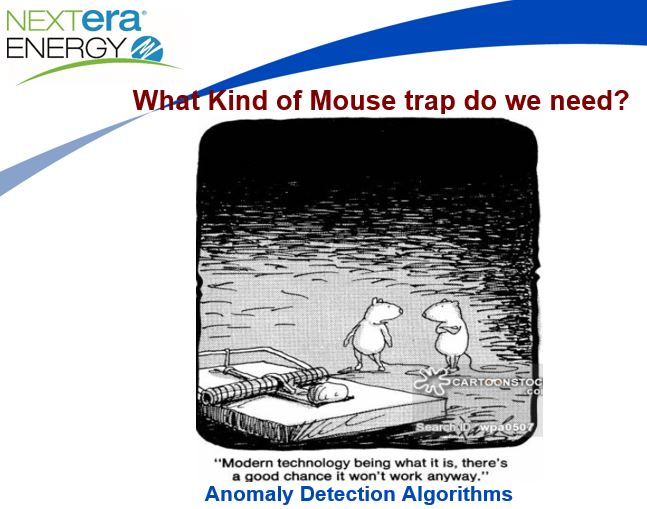

from IPython.display import Image
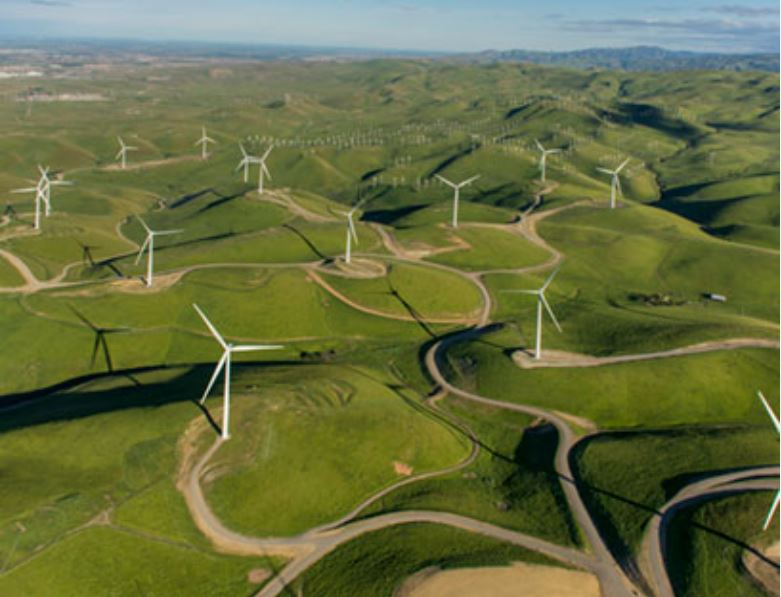

# Introduction:  Anomaly Detection in Time Series
This project is about detecting errors, outliers or any anomalous data points in time series.
Going forward in this project, all the above will be termed an anomaly if the following exist:
- An observation which deviates so much from other observations as to arouse suspicions that it was generated by a different mechanism relative to the general data population
- observations that data was either too high or low from the norm or even missing data.
Therefore, one can think of outliers or anomalies as observations that don’t follow expectations. 
# Background
Specifically, we are focus on errors or anomalies associated with financial systems erroneously recording expenses in their operations. For instance, I worked in FCOE that forecast for several wind farms across the country and each wind site has its own operating expenses that it record on a monthly basis.  However, the transcription of these expenses into the accounting system could be erroneously recorded for a variety of reasons such as human mis-typing numbers or even forgetting to input the expenses.  I have utilized several of the company's windsite financial data as test cases.  We will use these preliminary data sets first to test our theories and if it proves promising, will expand further with bigger and more diverse data sets and eventually productionalize this error detection alogrithm prototype into a process improvement tool for financial planning and accounting (FP&A) team.

# Problem Statement

Anomaly detections like fraud detection is a mousetrap; trying to catch an anomalous event/s that’s deviated from normal behavior. The question is what kind of mousetrap do we need to build in order to catch our mouse or mice effectively.  The objective is detect these infrequent events and throw flags at the end users (financial analysts) to investigate further and root cause the issues, as needed

# Description of the raw data
- The raw data came from the company's financial record keeping system
- It was retrieved as regular csv formatted files
- 3 csv files of actual expenses over several time periods were randomly chosen as test case
- First 2 files were used as both train/test for several of our classifier algorithms while the 3rd one was purely used to test if the model can be generalized

# Approach taken
- The univariate time series expense data was first "decomposed" to several statiscal data by computing the Z-scores, Std Dev, mean, Min/Max from the original expense data in order to create X features which then became the X design Matrix
- The y-vector (labelled data) of ones and zeros were also collected along side the expense data.  The ones denote errors while zeros denote normal or good data points.  This information came from the accounting system.
Visually, we are turning : Wide to Tall Data Table

from IPython.display import Image
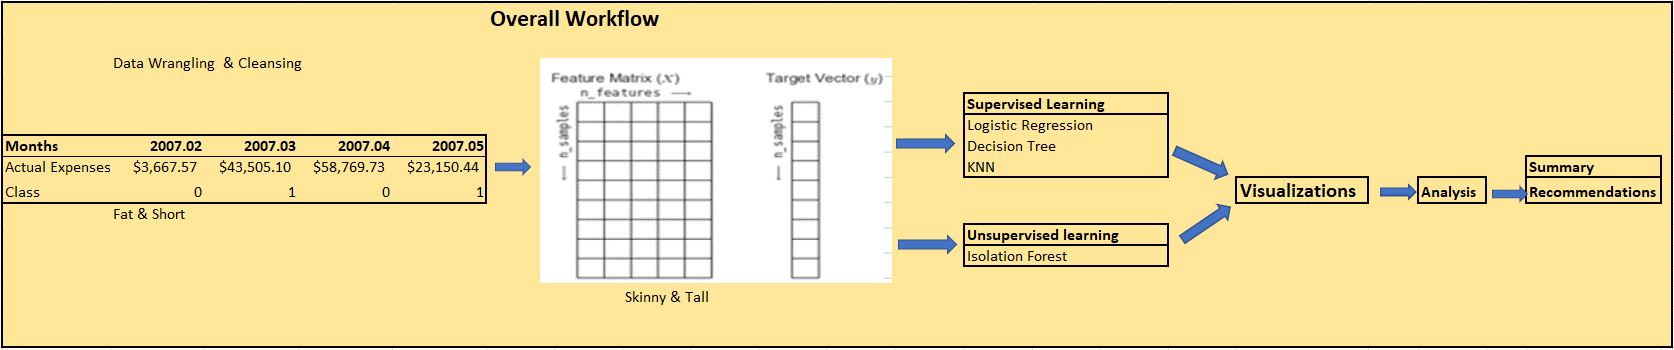

















We then used 2 approaches, one was to test our "self-created" X design Matrix with y-vectors of labels via supervised learning methodologies

- Supervised learning alogorithms:

a) Logistic Regression

b) KNN Neighbors

c ) Decision Tree

The other was to apply an unsupervised learning model to the univariate time series of expenses itself without any labels and NOT include any self-created attributes.  We only used the labels after the fact as ground truths to check for accuracy of the model

- Unsupervised Learning Algorithm:

a) Isolated Forest

- Importing all the necessary libraries

In [2]:
from __future__ import division
from itertools import count
from matplotlib import pyplot
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
from pandas import set_option
from pandas import read_csv
import sklearn
import scipy
import seaborn as sns; sns.set()
%matplotlib inline
# Types of Classification Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
plt.rcParams.update({'figure.figsize':(6,4)})
import warnings
warnings.filterwarnings('ignore')

C:\Users\s_suf\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- Reading in csv formatted raw data

- The first data set was "Indian Mesa", the name of the wind site.

In [3]:
#Reading Raw DAta Business Case (fat finger issue)
dataframe = pd.read_csv('IndianMesa_Train_rand3.csv')
print('Original Wide (panel) data set')
display(dataframe.head())
print(dataframe.shape)

Original Wide (panel) data set


,Months,2007.02,2007.03,2007.04,2007.05,2007.06,2007.07,2007.08,2007.09,2007.1,...,2015.11,2015.12,2016.01,2016.02,2016.03,2016.04,2016.05,2016.06,2016.07,2016.08
0,Actual Expenses,"$3,667.57","$43,505.10","$58,769.73","$23,150.44","$16,619.03","$35,497.65","$125,316.95","$24,304.69","$13,221.33",...,"$41,986.25","$64,491.94","$17,105.15","$19,275.00","$17,488.00","$16,985.00","$17,573.00","$12,443.75","$119,524.00","$57,062.00"
1,Class,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


(2, 116)


- The next several steps was to cleanse, wrangle the data for further analysis

1a) First off, make wide and fat data set into tall and skinny

1b) As shown, all data was recorded as text that will be converted into their appropriate dtypes

In [4]:
#Transforming wide panel data to long & skinny data set
dataframe1 = dataframe.transpose()
dataframe1.reset_index(inplace=True)
print('Dataframe with Messy column headers & row index')
display(dataframe1.head(5))
dataframe2=dataframe1.loc[1:,:]
#renaming column headers & removing first row:  Note that row index is now set to 1 as start value
dataframe2=dataframe2.rename(columns={'index':'Months', 0:'act_expenses',1:'class'})
print('Post cleaning Dataframe')
display(dataframe2.head(4))
dataframe2.info()
# # convert the 'Date' column to datetime format
dataframe2['Months']= pd.to_datetime(dataframe2['Months'])
print(dataframe2.Months.head(2))

Dataframe with Messy column headers & row index


,index,0,1
0,Months,Actual Expenses,Class
1,2007.02,"$3,667.57",0
2,2007.03,"$43,505.10",0
3,2007.04,"$58,769.73",0
4,2007.05,"$23,150.44",0


Post cleaning Dataframe


,Months,act_expenses,class
1,2007.02,"$3,667.57",0
2,2007.03,"$43,505.10",0
3,2007.04,"$58,769.73",0
4,2007.05,"$23,150.44",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 1 to 115
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Months        115 non-null    object
 1   act_expenses  115 non-null    object
 2   class         115 non-null    object
dtypes: object(3)
memory usage: 2.8+ KB
1   2007-02-01
2   2007-03-01
Name: Months, dtype: datetime64[ns]


In [5]:
# #converting currency string object to floats using regex
dataframe2['act_expenses']= dataframe2['act_expenses'].replace('[\$,]', '', regex=True)

In [6]:
dataframe2['act_expenses']=dataframe2['act_expenses'].astype(float)
display(dataframe2.act_expenses.head(2))

1     3667.57
2    43505.10
Name: act_expenses, dtype: float64

In [7]:
#converting class from text to integer
dataframe2['class']= dataframe2['class'].astype(int)
print(dataframe2['class'].dtype)

int32


In [8]:
#Now its fully cleaned & ready to be merged with another csv file
dataframe2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 1 to 115
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Months        115 non-null    datetime64[ns]
 1   act_expenses  115 non-null    float64       
 2   class         115 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 2.4 KB


- Reading in another set of data that contains statistical information from another csv file

1) Merging them together and performed more data wrangling

2) Finally, merged the 2 data sets into one dataframe via concatenation

In [9]:
#Reading another set of data that contain statistical information to use as predictors
df = pd.read_csv('IndianMesa_Train_rand_stats.csv')
print('Original data set containing stats info')
display(df.head(2))
df.info()

Original data set containing stats info


,Z-score,Mean,Std_Dev,Min,Max,Class
0,-1.698967,22478.248,11071.83532,8684.76,41222.66,0
1,1.754547,20072.240,13355.50725,3667.57,41222.66,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Z-score  115 non-null    float64
 1   Mean     115 non-null    float64
 2   Std_Dev  115 non-null    float64
 3   Min      115 non-null    float64
 4   Max      115 non-null    float64
 5   Class    115 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 5.5 KB


In [10]:
#converting class in 2nd dataset from int64 to regular int32 just so it's compatible during the merge
df['Class']= df['Class'].astype(int)
df['Class'].dtype

dtype('int32')

In [11]:
#shifting index to start from 1 instead of 0 to be compatible with original data when merging
df.index = np.arange(1, len(df) + 1)
df.head(2)

,Z-score,Mean,Std_Dev,Min,Max,Class
1,-1.698967,22478.248,11071.83532,8684.76,41222.66,0
2,1.754547,20072.240,13355.50725,3667.57,41222.66,0


# Cleaned Data
- The data is now properly cleaned and can be fed into the various algorithms
- The cleaned dataframe is called merged

In [12]:
#Using class as merging key variable during concat
merged=pd.concat([dataframe2,df], axis=1)
#Select only needed columns
merged=merged.loc[:,['Months','act_expenses','Z-score','Mean','Std_Dev','Min','Max','class']]
merged.head()

,Months,act_expenses,Z-score,Mean,Std_Dev,Min,Max,class
1,2007-02-01,3667.57,-1.698967,22478.248,11071.83532,8684.76,41222.66,0
2,2007-03-01,43505.10,1.754547,20072.240,13355.50725,3667.57,41222.66,0
3,2007-04-01,58769.73,2.170489,27036.308,14620.40274,3667.57,43505.10,0
4,2007-05-01,23150.44,-0.627299,34799.578,18570.30575,3667.57,58769.73,0
5,2007-06-01,16619.03,-0.920970,34063.100,18940.97475,3667.57,58769.73,0


In [13]:
set_option('display.width', 100)
set_option('precision', 3) 
description = merged.describe()
display(description)

,act_expenses,Z-score,Mean,Std_Dev,Min,Max,class
count,115.000,115.000,115.000,115.000,115.000,115.000,115.000
mean,39394.558,0.595,38618.043,36280.178,-4022.463,95799.011,0.113
std,50722.579,5.498,19594.070,28525.365,33852.152,66250.829,0.318
min,-108949.950,-12.473,-3054.104,825.309,-108949.950,13805.510,0.000
25%,13585.210,-0.792,25213.792,17067.201,613.590,52157.000,0.000
50%,23220.770,-0.379,38222.566,24389.616,7684.760,68077.230,0.000
75%,57534.665,0.992,49833.076,55606.564,12084.335,149319.570,0.000
max,265000.300,44.899,91437.598,109329.615,45679.440,265000.300,1.000


# Class size 
- 102 of zeros indication good normal data points
- 13 of ones indicating abnormal data points
- Class Imbalance:
This is the most critical part of the entire analysis.  Most machine learning algorithms assume data is equally distributed. So, when we have a class imbalance, the machine learning classifier tends to be more biased towards the majority class, causing bad classification of the minority class.  Therefore, before implementing the classification models, we need to check for imbalance of the minority class.  The minority class in this case is the set of errors or outliers. 

This could cause all sort of distortions in the analysis such as overfitting, low precision or recall rate.  We will address this in details later in the analysis section


class
0    102
1     13
dtype: int64

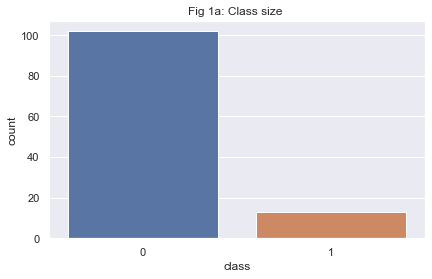

In [15]:
#class counts
class_counts = merged.groupby('class').size()
display(class_counts)

# plot Majority vs Minority Class size to check if dataset too disbalanced?
plt.title('Fig 1a: Class size ')
sns.set_style('darkgrid',{"xtick.major.size": 8, "ytick.major.size": 8})
sns.countplot(x='class', data=merged);
# ax.set_facecolor('xkcd:lightblue')

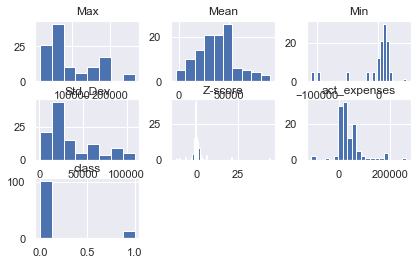

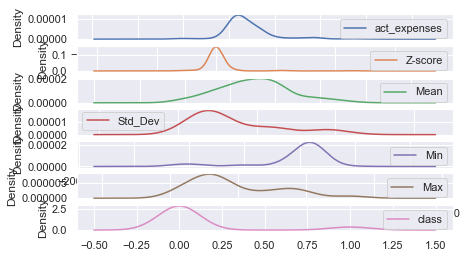

In [16]:
#plot of distribution
merged.hist(bins='auto') 
merged.iloc[:,1:].plot(kind='density', subplots=True,sharex=False)
pyplot.show()

# Creating X Design Matrix & y-vector (labels)

In [17]:
# creating X-Matrix(Feature Matrix) and Y-Vector
X = merged.drop(['Months','class'],axis=1)
print('X sample dataframe after drop Months and Class columns')
display(X.head(2))

Y = merged['class']
print('Y sample Vector')
display(Y.head(2))

X sample dataframe after drop Months and Class columns


,act_expenses,Z-score,Mean,Std_Dev,Min,Max
1,3667.57,-1.699,22478.248,11071.835,8684.76,41222.66
2,43505.10,1.755,20072.240,13355.507,3667.57,41222.66


Y sample Vector


1    0
2    0
Name: class, dtype: int32

# 3 classification models (Supervised learning)
- LogisticRegression
- KNeighborsClassifier
- DecisionTree

In [20]:
#function to call different classifier & fitting model to data sets
seed = 7
split=1-testsize
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=testsize, random_state=seed,shuffle=False)
def classifier(modeltype, testsize):
#choosing different kinds of classifiers
    target_names = ['Class 0', 'Class 1']
    if modeltype == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(criterion="gini", splitter="best",random_state=seed)
    elif modeltype=='LogisticRegression':
        model = LogisticRegression(class_weight='balanced')
    else:
        model = KNeighborsClassifier(n_neighbors=5, weights='distance')#optimal k from elbow plot

    #fitting different models
    model.fit(X_train, Y_train)
    result = model.score(X_test, Y_test)
    print(f"{modeltype} Accuracy score based on {split}/{testsize} split :", \
              format((result*100.0), ".3f"))
    predicted = model.predict(X_test)
    #Accuracy reporting 
    report = classification_report(Y_test, predicted, target_names=target_names)
    print(report)
    # Compute confusion matrix
    cnf_matrix  = confusion_matrix(Y_test, predicted)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    print('Confusion Matrix:')
    display(cnf_matrix )
    # Plot Actuals vs. Predicted Values
    fmt = '{:<8}{:<20}{}'         
    print(fmt.format('', 'Y Actuals', 'Predicted'))
    for i, (Y_acts, Y_pred) in enumerate(zip(Y_test, predicted)):
        print(fmt.format(i, Y_acts, Y_pred))

    df1 = pd.DataFrame()
    df1['Y_acts']=Y_test
    df1['Y_pred']=predicted
    df1['True/False']=False
    df1.loc[(df1['Y_acts']==df1['Y_pred']),'True/False']=True
    df1 #Y_acts, Y_pred
    df1.reset_index(inplace=True, drop=True)
    df1.plot(style=['o','rx'])
    # Add title and axis names
    plt.title(f'Fig 1b: {modeltype} Plot of Acts vs Predicted')
    grp=df1.groupby(['True/False'], as_index=True).agg(count=('True/False','count'))
    print('How many was classified correctly?')
    display(grp)
    return None

# "GUI" for end users
- Select and run the 3 classifier models
- Enduser can selectively pick which classifier to run and review the results by uncommenting lines

LogisticRegression Accuracy score based on 0.6/0.4 split : 60.870
              precision    recall  f1-score   support

     Class 0       0.96      0.60      0.74        42
     Class 1       0.15      0.75      0.25         4

    accuracy                           0.61        46
   macro avg       0.56      0.67      0.49        46
weighted avg       0.89      0.61      0.69        46

Confusion Matrix:


array([[25, 17],
       [ 1,  3]], dtype=int64)

        Y Actuals           Predicted
0       0                   0
1       0                   0
2       0                   0
3       0                   0
4       0                   0
5       0                   1
6       0                   1
7       0                   1
8       0                   1
9       1                   1
10      0                   0
11      0                   0
12      0                   0
13      0                   0
14      0                   0
15      0                   0
16      0                   0
17      0                   1
18      0                   1
19      0                   0
20      1                   0
21      0                   1
22      0                   1
23      0                   1
24      0                   1
25      0                   1
26      0                   0
27      0                   1
28      0                   0
29      0                   0
30      0                   0
31      0                   1
32

,count
True/False,
False,18
True,28


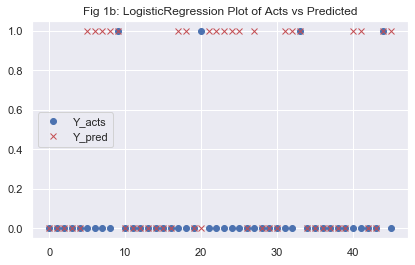

In [21]:
#Enduser Data Entry Platform - Note to self:  Build a better GUI
testsize=0.4
modeltype='LogisticRegression'
# modeltype='KNeighborsClassifier'
# modeltype='DecisionTreeClassifier'
#Run the function
classifier(modeltype, testsize)

# Elbow Plot 
- Elbow plot was utilized to determine optimal k values to use in KNN classifier

Text(0, 0.5, 'Error Rate')

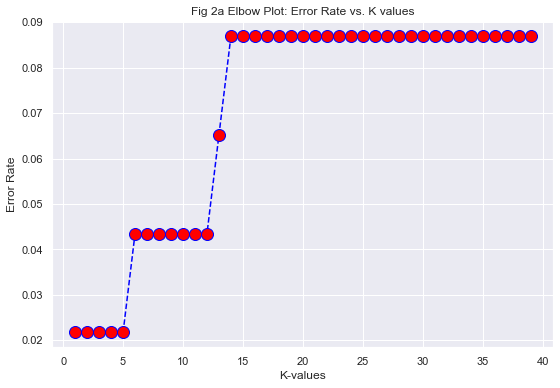

In [22]:
# Elbow method to determine optimal K value
error_rate = []

for i in range(1,40):
    model = KNeighborsClassifier(n_neighbors=i, weights='distance')
    model.fit(X_train, Y_train)
    pred_i = model.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))
# Plot error rate vs K values
plt.figure(figsize=(8,6))
plt.plot(range(1,40),error_rate, color='blue',linestyle = '--', marker='o',markerfacecolor='red',markersize=12)

plt.title('Fig 2a Elbow Plot: Error Rate vs. K values')
plt.xlabel('K-values')
plt.ylabel('Error Rate')

# Summary of initial test results
- They say looks can be deceiving.  The overall accuracies of the 3 models looks good, in fact, too good to be true.  Let's disect it a little more:

1) KNN:  Optimal k values = 5 via the elbow plot, the overall accuracy rate = 97.8%

Precision: 1.0 and Recall: 0.75 f1-score: 0.86

2) Logistic Regression:  overall accuracy rate = 60.8%

Precision: 0.15 and Recall: 0.75 f1-score: 0.25

3) Decision Tree:  overall accuracy rate = 100.0% !!!!

Precision: 1.0 and Recall: 1.0  f1-score: 1.0 

- There were multiple reasons the results look suspiciously overfitted at one extreme vs underfitting in the other.  The obvious one was not having trained these models with enough data.  An easy solution would be to try different test sizes (currently 60/40 split) in conjunction with bigger sample size.

- Since we have very small number of class 1 (errors), we could have a disbalanced of the minority class in our hands.  

note:  Since label 1 is the "anomoulous" class, we will focus only on these

# Testing on another data set to see if these models generalized?

-Since, we did not get a reasonable results from our first data set (Site: Indian Mesa), the obvious next steps is to expand on our findings by experimenting on bigger, different and more diverse data sets

-Let's try it on a different site => Wind site: "Brady"

-For the sake of expediency, we will not do any pre-cleaning on the raw data but instead bring in

-pre-cleaned data and go straight into the algorithms themselves

In [23]:
#Brady is the name of a differnt Wind Site
df_brady = pd.read_csv('Wind_Blind_Test_data_set.csv')
print('Another data set to test our findings')
display(df_brady.head(2))
print(df_brady.shape)

Another data set to test our findings


,Months,Actual Expense,Z-score,Mean,Std,Max,Min,Class
0,2007-01,13420.0,1.0,1.0,1.0,1.0,1.0,0
1,2007-02,4162.0,1.0,1.0,1.0,1.0,1.0,0


(178, 8)


In [47]:
class_counts = df_brady.groupby('Class').size()
display(class_counts)

Class
0    147
1     31
dtype: int64

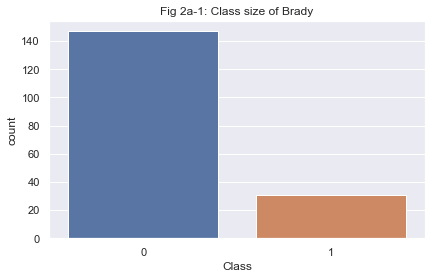

In [25]:
# plot Majority vs Minority Class size to check if dataset too disbalanced?
plt.title('Fig 2a-1: Class size of Brady')
sns.set_style('darkgrid',{"xtick.major.size": 8, "ytick.major.size": 8})
sns.countplot(x='Class', data=df_brady);
# ax.set_facecolor('xkcd:lightblue')

In [26]:
#info on brady windsite
print(df_brady.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Months          178 non-null    object 
 1   Actual Expense  178 non-null    float64
 2   Z-score         178 non-null    float64
 3   Mean            178 non-null    float64
 4   Std             178 non-null    float64
 5   Max             178 non-null    float64
 6   Min             178 non-null    float64
 7   Class           178 non-null    int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 11.2+ KB
None


X sample dataframe after drop Months and Class columns for Brady Windsite


,Actual Expense,Z-score,Mean,Std,Max,Min
0,13420.0,1.0,1.0,1.0,1.0,1.0
1,4162.0,1.0,1.0,1.0,1.0,1.0


Y sample Vector for Brady Windsite


0    0
1    0
Name: Class, dtype: int64

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) Accuracy score based on 0.6/0.4 split : 100.000
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        62
     Class 1       1.00      1.00      1.00        10

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

How many was classified correctly?


,count
True/False,
True,72


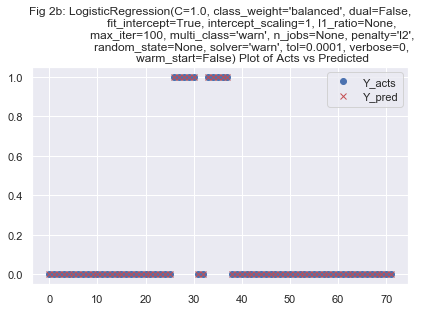

In [27]:
# creating X-Matrix(Feature Matrix) and Y-Vector now for the new unseen dataset: Brady Windsite
X_brady = df_brady.drop(['Months','Class'],axis=1)
print('X sample dataframe after drop Months and Class columns for Brady Windsite')
display(X_brady.head(2))
Y_brady= df_brady['Class']
print('Y sample Vector for Brady Windsite')
display(Y_brady.head(2))
#Partitioning datasets
Xbrady_train, Xbrady_test, Ybrady_train, Ybrady_test = train_test_split(X_brady, Y_brady, test_size=testsize, \
                                                       shuffle = False, random_state=seed)

#Run classifier
# model_brady = DecisionTreeClassifier(criterion="gini", splitter="best",random_state=seed)
model_brady= LogisticRegression(class_weight='balanced')
# model_brady = KNeighborsClassifier(n_neighbors=5, weights='distance')#optimal k from elbow plot

#fitting different models
target_names = ['Class 0', 'Class 1']
model_brady.fit(Xbrady_train, Ybrady_train)
result_brady = model_brady.score(Xbrady_test, Ybrady_test)
print(f"{model_brady} Accuracy score based on {split}/{testsize} split :", \
              format((result_brady*100.0), ".3f"))
predicted_brady = model_brady.predict(Xbrady_test)
    #Accuracy reporting 
report_brady = classification_report(Ybrady_test, predicted_brady, target_names=target_names)
print(report_brady)

df2 = pd.DataFrame()
df2['Y_acts']=Ybrady_test
df2['Y_pred']=predicted_brady
df2['True/False']=False
df2.loc[(df2['Y_acts']==df2['Y_pred']),'True/False']=True
df2 #Y_acts, Y_pred
df2.reset_index(inplace=True, drop=True)
df2.plot(style=['o','rx'])
    # Add title and axis names
plt.title(f'Fig 2b: {model_brady} Plot of Acts vs Predicted')
grp2=df2.groupby(['True/False'], as_index=True).agg(count=('True/False','count'))
print('How many was classified correctly?')
display(grp2)
testsize=0.2


# Summary results of 2nd data set

- Again, the results looked too good to be true!  Here's a quick summary of the runs:

1) KNN:  Optimal k values = 5 via the elbow plot, the overall accuracy rate = 98.6!

Precision: 0.91 and Recall: 1.0 f1-score: 0.95

2) Logistic Regression:  overall accuracy rate = 98.6!

Precision: 0.91 and Recall: 1.0 f1-score: 0.95

3) Decision Tree:  overall accuracy rate = 100.0% !!!!

Precision: 1.0 and Recall: 1.0  f1-score: 1.0 

- The poor performance from second run with 80/20 split and a slightly bigger sample size did not remedied the situation

- The proper next step if we were to continue the supervised learning route is to apply an over sampling procedure of the minority class.  Therefore, in the next vetting phase, systematic SMOTE processes will be applied along with bigger sample size if its available

# Observation 1

- In the first and second test cases, the realistic results came from logistic regression whereby the overall accuracy rate is 60% and the recall and precision were 75% and 15% respectively.  Precision which measure proportion of correct positive identifications was poor.  In other words, this metric tells us when predicted True, how often is it correct?  Therefore of the anomoulous data points that were called (75%) only 15% were accurately called.  So a really low accuracy rate

- The rest of the resuluts as alluded to earlier, appeared to be overfitted due to a disbalanced data set and the models not appropiately trained.

# IsolationForest anomaly detection model

- The preliminary results from the previous section can be improved with regards to overfitting through various techniques or even using other models such as Random Forest but in reality, getting labelled data is a time consuming affair, adminstratively.  

-So lets see if we can utilzed some unsupervised learning techniques to detect anamoulous data points? 

This will bypass the adminstrative cost of collecting label information altogether

- Classification and Regression Trees (CART) via Isolation Forest which detects anomalies purely 
based on the fact that anomalies are data points that are few and different.
The nifty part about this is the anomalies isolationForest is implemented without employing any distance or density measure.

In [28]:
#To remind ourselves, let's print out how the merged data looks like again 
merged.head(2)

,Months,act_expenses,Z-score,Mean,Std_Dev,Min,Max,class
1,2007-02-01,3667.57,-1.699,22478.248,11071.835,8684.76,41222.66,0
2,2007-03-01,43505.10,1.755,20072.240,13355.507,3667.57,41222.66,0


# Dimensionality reduction via SVD 

- Of the attributes that we self-created, can we eliminate some of them if they do not carry alot of information?

In [29]:
#Use SVD to ID which predictors carry the most variance that's worth keeping
cols=['act_expenses','Z-score','Mean','Std_Dev','Min','Max']
#Extracting only the numiricals from merged Dataframe
X_raw=merged[cols].values
X_raw.shape
X = X_raw - np.mean(X_raw, axis=0)#mean-centered
X.shape

(115, 6)

In [30]:
#Applying linalg function to decomposed the X-mean centered matrix:U, Sigma and VT
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
print("U:", U.shape)
print("Sigma:", Sigma.shape)
print("VT:", VT.shape)

U: (115, 6)
Sigma: (6,)
VT: (6, 6)


Square root of Sigma (eigenvalues): [889.99 739.93 592.72 312.41 164.78   6.73]


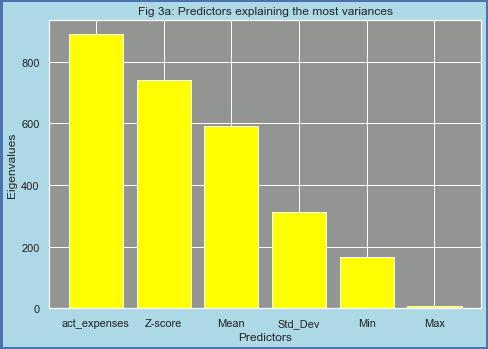

In [31]:
print('Square root of Sigma (eigenvalues):', np.sqrt(Sigma))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4),edgecolor='b',facecolor='lightblue',linewidth=5)
ax = fig.add_axes([0,0,1,1])
cols=['act_expenses','Z-score','Mean','Std_Dev','Min','Max']
eigenvalues = [np.sqrt(Sigma[0]),np.sqrt(Sigma[1]),np.sqrt(Sigma[2]),\
               np.sqrt(Sigma[3]),np.sqrt(Sigma[4]),np.sqrt(Sigma[5])]
ax.bar(cols,eigenvalues, color='yellow')
ax.set_facecolor('xkcd:grey')
plt.xlabel("Predictors")
plt.ylabel("Eigenvalues")
plt.title("Fig 3a: Predictors explaining the most variances")
plt.show();

# Observation 2
- No surprise the original univariate expense time series itself carried the most variance 

-Let's keep things simple and 2-Dimensional by retaining the first 2 biggest eigenvalues and
run it thru Isolation Forest and see how it performed?

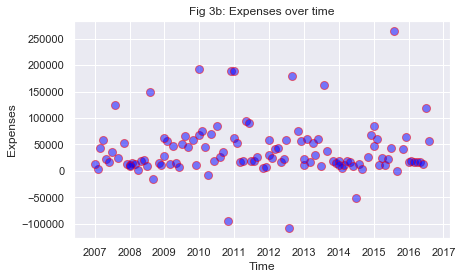

In [32]:
#(1) Expenses 
plt.rc('font',size=15)
plt.title("Fig 3b: Expenses over time")
plt.scatter(merged.loc[:,['Months']], merged.loc[:,['act_expenses']], \
color='blue',s=65,alpha=0.5,edgecolors='red')
plt.xlabel('Time')
plt.ylabel('Expenses')
plt.show()

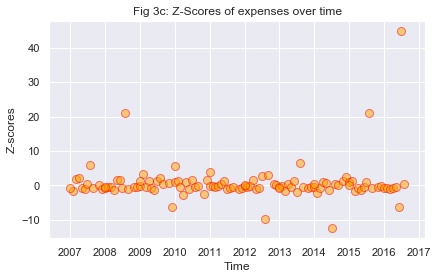

In [33]:
#(2) Z-score of the expenses
plt.rc('font',size=15)
plt.title("Fig 3c: Z-Scores of expenses over time")
plt.scatter(merged.loc[:,['Months']], merged.loc[:,['Z-score']], c='orange',s=65,alpha=0.5,edgecolors='red')
plt.xlabel('Time')
plt.ylabel('Z-scores')
plt.show()



- We ran the model using both actual expense (the original time series data) and z-scores

- Only the results from actual expenses are shown here.  The results looks promisingly good


In [34]:
#making a copy of merged to start a new analysis to feed into Isolation Forest
merged1=merged.copy()
#The most important hyperparameter to tweak!!
outliers_fraction = float(.11)#needs to toggle and play with this parameter

In [35]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(merged1['act_expenses'].values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

merged1['anomaly'] = model.predict(data)

In [36]:
model.predict(data)

array([ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1])

In [37]:
merged1.query('anomaly==-1')

,Months,act_expenses,Z-score,Mean,Std_Dev,Min,Max,class,anomaly
7,2007-08-01,125316.95,6.015,35508.390,14930.266,16619.03,58769.73,1,-1
19,2008-08-01,149319.57,20.963,12632.858,6520.271,2348.89,20828.56,1,-1
45,2010-01-01,192727.46,5.689,46873.906,25639.878,18741.14,84612.17,1,-1
46,2010-11-01,-95090.75,-2.570,71539.860,64824.237,18741.14,192727.46,1,-1
47,2010-12-01,189700.91,1.513,48773.482,93163.753,-95090.75,192727.46,0,-1
52,2011-05-01,95090.75,0.427,68010.450,63351.676,17105.15,189700.91,0,-1
57,2011-01-01,189700.91,3.999,49743.298,35001.497,17808.00,95090.75,1,-1
67,2012-08-01,-108949.95,-9.639,36658.286,15106.275,16619.03,58769.73,1,-1
68,2012-09-01,180062.95,2.906,6623.764,59685.107,-108949.95,58769.73,1,-1
79,2013-08-01,162376.57,6.394,33556.024,20147.277,8940.22,60668.56,1,-1


In [38]:
#All the anomalies predicted by Isolation Forest
merged1[(merged1['class']==1)& (merged1['anomaly']==-1 )]

,Months,act_expenses,Z-score,Mean,Std_Dev,Min,Max,class,anomaly
7,2007-08-01,125316.95,6.015,35508.390,14930.266,16619.03,58769.73,1,-1
19,2008-08-01,149319.57,20.963,12632.858,6520.271,2348.89,20828.56,1,-1
45,2010-01-01,192727.46,5.689,46873.906,25639.878,18741.14,84612.17,1,-1
46,2010-11-01,-95090.75,-2.570,71539.860,64824.237,18741.14,192727.46,1,-1
57,2011-01-01,189700.91,3.999,49743.298,35001.497,17808.00,95090.75,1,-1
67,2012-08-01,-108949.95,-9.639,36658.286,15106.275,16619.03,58769.73,1,-1
68,2012-09-01,180062.95,2.906,6623.764,59685.107,-108949.95,58769.73,1,-1
79,2013-08-01,162376.57,6.394,33556.024,20147.277,8940.22,60668.56,1,-1
90,2014-07-01,-51301.31,-12.473,12336.026,5102.134,5621.45,18652.68,1,-1
103,2015-08-01,265000.30,20.983,22479.322,11557.882,10976.17,42648.68,1,-1


In [39]:
#The one class Isolation Forest Mis-Predicted
merged1[(merged1['class']==0) & (merged1['anomaly']==-1 )]

,Months,act_expenses,Z-score,Mean,Std_Dev,Min,Max,class,anomaly
47,2010-12-01,189700.91,1.513,48773.482,93163.753,-95090.75,192727.46,0,-1
52,2011-05-01,95090.75,0.427,68010.450,63351.676,17105.15,189700.91,0,-1


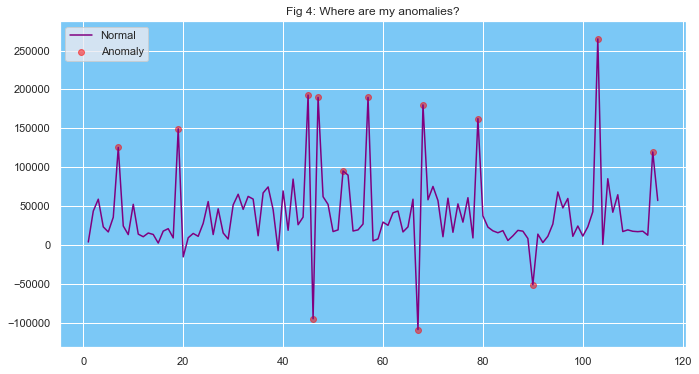

In [40]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = merged.loc[merged1['anomaly'] == -1, ['act_expenses']] #anomaly
ax.plot(merged1.index, merged1['act_expenses'], color='purple', label = 'Normal')
ax.scatter(a.index,a['act_expenses'], color='red', label = 'Anomaly',alpha=0.5)
plt.title("Fig 4: Where are my anomalies?")
ax.set_facecolor('xkcd:lightblue')
plt.legend()
plt.show();

# Summary of results using Isolation Forest 

- The results looked very promising and has alot of potential.  The accuracy rate is 92%, using the known labelled class as ground truth for validation

- Besides the high level of accuracy, it was very easy to implement.  The only hypeparameter novice like myself had to be aware is the contamination parameter.  The default is usually recommended per its documentation.  However, this could be easily tuned for better results depending on circumstances.

- Isolation Forests(IF), like its cousin: Random Forests, are build based on decision trees. And since there are no pre-defined labels here, it is an unsupervised model.

- IsolationForests were built based on the fact that anomalies are the data points that are “few and different”.

- In an Isolation Forest, randomly sub-sampled data is processed in a tree structure based on randomly selected features. The samples that travel deeper into the tree are less likely to be anomalies as they required more cuts to isolate them. Similarly, the samples which end up in shorter branches indicate anomalies as it was easier for the tree to separate them from other observations; an outlier for instance


- Pros

The biggest advantage of this technique is you can introduce as many random variables or features as you like to make more sophisticated models

Ease of implmentation

- Cons

Like all tree-based algorithms, end users do not really see or understand how the end results came about.  End users usually see the improvements but do not really understand how the results got better because it's harder to explain and interpret the overall results

The weakness is that a growing number of features can start to impact your computational performance fairly quickly. In this case, one should select features carefully

When new data comes and if there was a regime change, the original Isolation Forest would not apply to the new shifted data because it's still taking into account the old data structure

# Proposed next Steps for Supervised learning

- In order to improved the supervised learning models, we can do the following:

Techniques to fight imbalanced data

-	Up sample the minority class
-	Down sample the majority class (only enough sample of the minority class)
-	Generate Synthetic Samples like SMOTE

- Use algorithm like Random Forest or XGBoost to potentially improved the supervised learning results

- Obviously increase sample size using different bigger and more diverse datasets

- And finally, remove all the "self-created statistical attributes" and simply run the models with the original time series of expenses.  Perhaps adding these features was not value-added to the performance of the models

- To reduce class noise, by validating the ground truth labels collection process 

# Unsupervised Learning

- Since Isolation Forest looked promising, we definitely will explore it further with bigger and more diverse data sets.  Try to understand why and how this algorithm improve the performance

- In other words, try to understand how these tree-based algorithms have superior results


In [ ]:
    #Accuracy reporting for unsupervised learning
    report = classification_report((merged1['class']==1), (merged1['anomaly']==-1 ), target_names=target_names)
    print(report)